# Modelo de Prediccion de Imagenes


## Cargar Librerias

In [14]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import pickle
from tensorflow.keras.preprocessing import image

## 2.1 Cargar Datos

Cargamos la base de datos caltech-101 desde un directorio local

In [15]:
# Directorio donde se encuentran las imágenes
data_dir = 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101'

In [16]:
# Cargar las imágenes desde el directorio

# Se usa para cargar las imágenes de training
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training", 
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Se usa para cargar las imágenes de test
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="validation", 
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 9144 files belonging to 102 classes.
Using 7316 files for training.
Found 9144 files belonging to 102 classes.
Using 4572 files for validation.


Si el total de imágenes en tu dataset es 𝑋, entonces:
- El conjunto de entrenamiento tendrá 0.8𝑋 imágenes.
- El conjunto de prueba/validación tendrá 0.2𝑋 imágenes.

Por lo que especificamente se tendria: 
Total de imágenes 
𝑋 ≈ 7316 + 1828 = 9144
- Conjunto de entrenamiento: 0.8 × 9144 ≈ 7316 imágenes.
- Conjunto de prueba/validación: 0.2 × 9144 ≈ 1828 imágenes.

In [17]:
# Obtener las rutas de las imágenes
def get_image_paths(directory, split):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
    # Dividir las rutas en conjunto de entrenamiento y prueba
    num_images = len(image_paths)
    split_idx = int(num_images * split)
    return image_paths[:split_idx], image_paths[split_idx:]

In [18]:
# Obtener las rutas de las imágenes para los datasets
train_image_paths, test_image_paths = get_image_paths(data_dir, 0.8)

## 2.2 Preprocesamineto de las imagenes

Usamos las librerias VGG16 y tensorflow.keras.models

In [21]:
# Obtener el número de clases
class_names = train_dataset.class_names
num_classes = len(class_names)

In [22]:
# Preprocesar las imágenes 
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplicar la función de preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

## 2.3 Extraccion de Caracteristicas


In [23]:
# Cargar el modelo VGG16 con pesos preentrenados
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Crear un nuevo modelo que produzca los mapas de características
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [24]:
# Función para extraer características junto con rutas de archivos
def extract_features(dataset, image_paths):
    features = []
    labels = []
    for batch, image_path in zip(dataset, image_paths):
        images, lbls = batch
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels, image_paths

In [25]:
# Extraer características para los conjuntos de datos de entrenamiento y prueba
train_features, train_labels, train_image_paths = extract_features(train_dataset, train_image_paths)
test_features, test_labels, test_image_paths = extract_features(test_dataset, test_image_paths)

1/1 [==============================] - 5s 5s/step


## 2.4 Indexacion

In [26]:
# Crear un índice usando k-NN
knn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(train_features.reshape(train_features.shape[0], -1))

# Guardar el índice y las rutas de las imágenes
index_data = {
    'knn': knn,
    'train_image_paths': train_image_paths
}

with open('knn_index1.pkl', 'wb') as f:
    pickle.dump(index_data, f)

## 2.5 Motor de Búsqueda

In [27]:
# Función para buscar imágenes similares
def search_image(query_image, knn_index, train_image_paths, k=5):
    query_features = model.predict(query_image[np.newaxis, ...])
    distances, indices = knn_index.kneighbors(query_features.reshape(1, -1), n_neighbors=k)
    similar_image_paths = [train_image_paths[i] for i in indices[0]]
    return similar_image_paths, distances[0]

In [28]:
# Función para cargar y preprocesar una imagen que no sea parte del dataset
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32) / 255.0
    return img_array

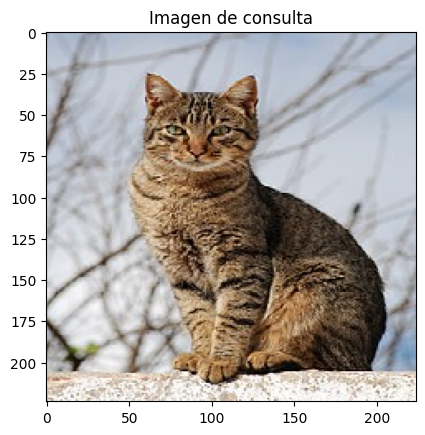

In [29]:
# Ruta de la imagen que no es parte del dataset
query_img_path = 'C:\\Users\\matte\\OneDrive\\Escritorio\\Cat_November_2010-1a.jpg'  # Cambia esta ruta a la de tu imagen de consulta
query_image = load_and_preprocess_image(query_img_path)

# Mostrar la imagen de consulta
plt.imshow(query_image.numpy())
plt.title('Imagen de consulta')
plt.show()

In [31]:
# Realizar la búsqueda
with open('knn_index1.pkl', 'rb') as f:
    index_data = pickle.load(f)

similar_image_paths, distances = search_image(query_image, index_data['knn'], index_data['train_image_paths'])

# Imprimir resultados
print("Índices de las imágenes más similares:", similar_image_paths)
print("Distancias a las imágenes más similares:", distances)

1/1 [==============================] - 0s 133ms/step
Índices de las imágenes más similares: ['D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101\\crocodile_head\\image_0005.jpg', 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101\\electric_guitar\\image_0045.jpg', 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101\\Motorbikes\\image_0383.jpg', 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101\\dolphin\\image_0007.jpg', 'D:\\U\\7. Septimo\\RI\\ir24a\\week14\\caltech-101\\Faces_easy\\image_0418.jpg']
Distancias a las imágenes más similares: [49.89988018 50.43509254 50.49400011 50.77670652 50.78959178]


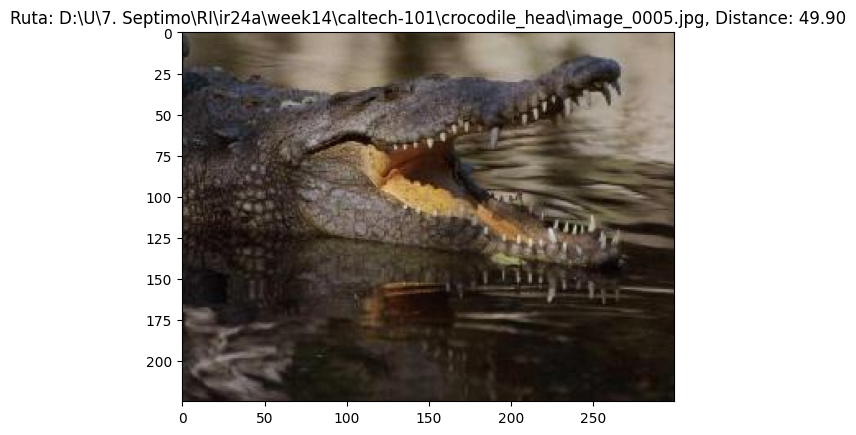

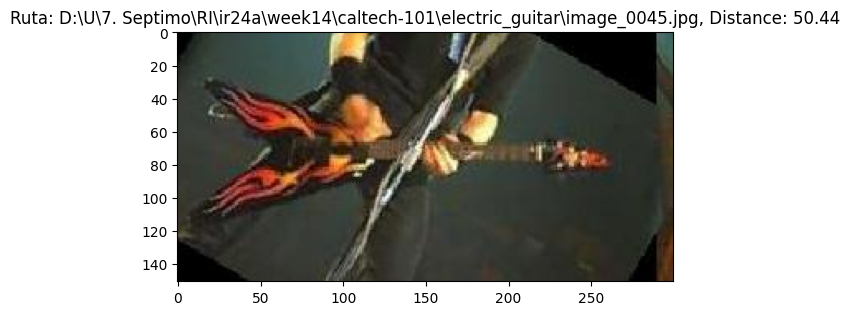

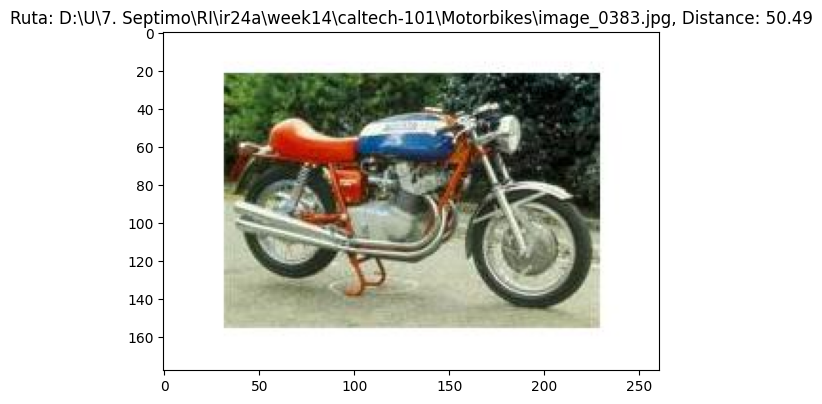

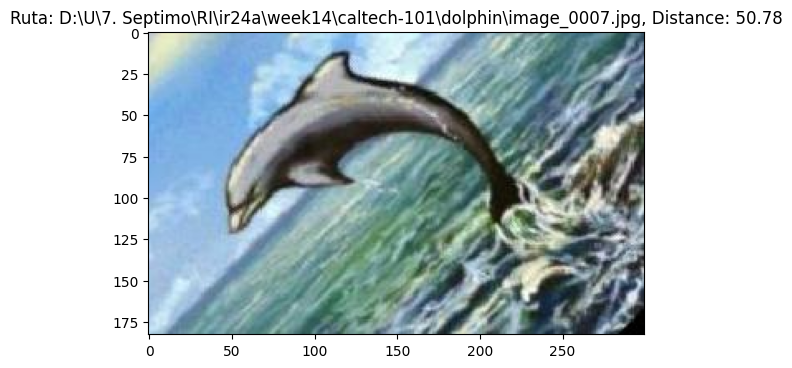

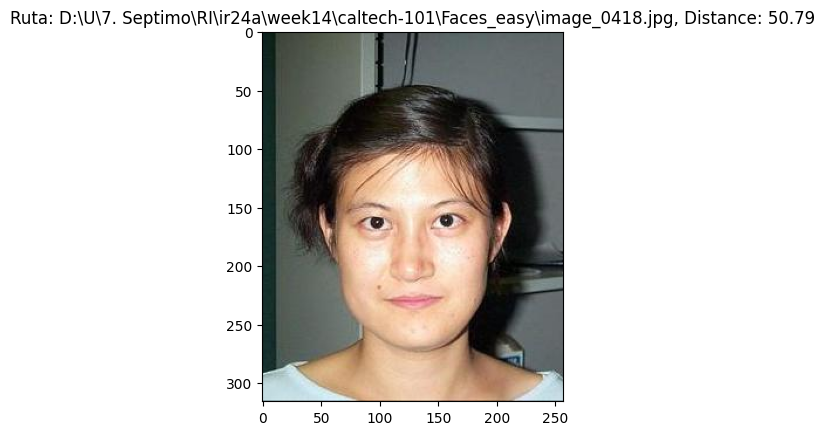

In [32]:
# Mostrar las imágenes más similares
for path, dist in zip(similar_image_paths, distances):
    similar_image = image.load_img(path)
    plt.imshow(similar_image)
    plt.title(f'Ruta: {path}, Distance: {dist:.2f}')
    plt.show()

## 2.7 Evaluación del Sistema

In [33]:
# Evaluar el sistema
def evaluate_system(test_features, test_labels, knn_index):
    y_true = []
    y_pred = []
    for i in range(len(test_features)):
        query_features = test_features[i]
        distances, indices = knn_index.kneighbors(query_features.reshape(1, -1), n_neighbors=1)
        y_true.append(test_labels[i])
        y_pred.append(train_labels[indices[0][0]])
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

precision, recall, f1 = evaluate_system(test_features, test_labels, index_data['knn'])
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


Precision: 0.879860402271723, Recall: 0.8337983484040111, F1-Score: 0.8448084489325909


In [34]:
# Guardar el modelo utilizado para la extracción de características en un archivo .h5
model.save('modelo1.h5')

d:\U\7. Septimo\RI\Proyecto-IIB-RI\proy\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
